# Gradients and Hessians without tears: Demonstration of automatic differentiation in Julia using ForwardDiff.jl

## This is copy of Matias Quiroz' notebook for Python.
## Translated by Mattias Villani to Julia.

## Purpose
This document demonstrates how to use automatic differentiation in Julia using the ForwardDiff package. If you want to know more about automatic differentiation [here](https://slides.com/robsal/autodiff/fullscreen) are some great resources (disclaimer: The author is my friend): 

## Example
A simple example with a simulated Poisson regression dataset is used for illustration. The idea is to estimate the parameters using the maximum likelihood method, which requires the gradient and Hessian of the model. <font color='red'>Personal opinion</font>: Students should learn how to obtain maximum likelihood estimates (MLE) by numerical optimisation. 

## Model and estimation 
The Poisson regression model is $$p(y_i|\beta,x_i)= \frac{\mu_i^{y_i}\exp(-\mu_i)}{y_i!}, y_i \in \mathbb{Z}^+,$$
where $\mu_i = \exp(x_i^\top \beta) \geq 0$. Note that $\mathrm{E}(y_i|\beta,x_i)=\mu_i$.

The log-likelihood based on $y=(y_1, \dots, y_n)$ independent observations is 
$$\ell(\beta|y) = \sum_{i=1}^n \log p(y_i|\beta,x_i) = \sum_{i=1}^n {y_i}\log(\mu_i)-\mu_i-\log(y_i!).$$
The maximum likelihood estimator is defined as
$$\beta^\star = \underset{\beta}{\operatorname{argmax}} \ell(\beta|y),$$
and under some regularity conditions it can be shown that
$$\mathrm{V}(\beta^\star) = -\left( \nabla \nabla^\top \ell(\beta^\star|y) \right)^{-1}.$$

## Optimisation
We obtain the MLE using gradient ascent. Starting from $\beta^{(0)}$, we iterate
$$\beta^{(j)} = \beta^{(j-1)} + \gamma \nabla \ell(\beta^{(j-1)}|y) $$
where $\gamma > 0$ is the step-size, until some convergence criteria is met.

It can be shown that if $\gamma$ mimics the local curvature (given by the Hessian) of the objective function, then the optimisation achieves optimal convergence rate. This happens when $\gamma = -\left(\nabla \nabla^\top \ell(\beta|y)\right)^{-1}$, in case this is known as <font color='red'>Newton's method</font>, or <font color='red'>Newton-Raphson method</font>.

## Task
To carry out the optimisation we need the gradient and the Hessian of the model, which we <font color='red'>compute using automatic differentiation</font>. 

Why bother?
- No need to derive gradients or Hessians by hand. The chain-rule can be a pain, especially in the vector calculus world.
- <font color='red'>Much faster than numerical gradients and Hessians obtained by finite difference methods</font>. Automatic differentiation is basically the computer's way of doing the chain-rule.
- Works on ALL <font color='red'></font> Julia functions. 
- You can also use an already available optimiser (e.g. maximize in Optim.jl). This optimiser will use finite differences if you do not supply the gradient and Hessian yourself, but you can use :ForwardDiff as argument without supplying gradients and hessians.

# Let's get started

Import a bunch of packages (add if not already installed) and set seed.

In [65]:
using Optim, ForwardDiff, Distributions, LinearAlgebra
using Plots, SpecialFunctions, Random
Random.seed!(123);

## Simulate a dataset

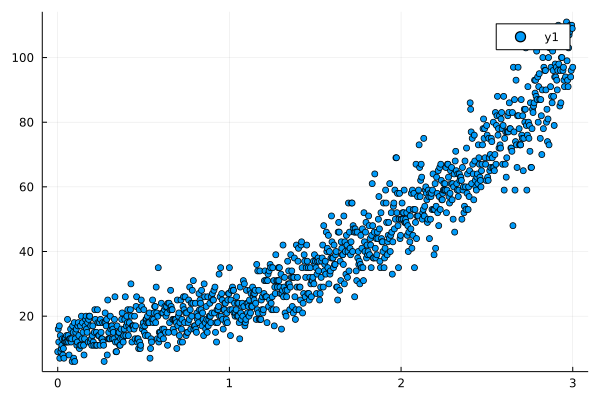

In [66]:
n = 1000
βₜ = [2.5, 0.7]
X = [ones(n) LinRange(0,3,n)]
y = rand.(Poisson.(exp.(X*βₜ)))
scatter(X[:, 2], y)

## Estimate parameters
- Write up the log-likelihood function.
- Compute the gradient and Hessian.
- Optimise the log-likelihood function.

In [67]:
function ℓ(β, X, y)
    μ = exp.(X*β)
    return sum(y.*log.(μ) - μ - logfactorial.(y))
end

# For the (extremely) lazy one
function ℓ_lazy(β, X, y)
    μ = exp.(X*β)
    return sum(logpdf.(Poisson.(μ), y))
end

# Test evaluating the function at true_params:
println(ℓ(βₜ, X, y))
println(ℓ(0.1*βₜ, X, y)) 

println(ℓ_lazy(βₜ, X, y))
println(ℓ_lazy(0.1*βₜ, X, y)) 

-3210.96386542123
-108069.03046442108
-3210.96386542123
-108069.03046442108


## This is literally all we need to do!

In [68]:
# Compute gradient and Hessian by automatic differentiation:
∇ᵦ(β) = ForwardDiff.gradient(β -> ℓ(β, X, y),β) # defines gradient function
∇ᵦ([0,0]) # Evaluate gradient at β = [0,0]
Hᵦ(β) = ForwardDiff.hessian(β -> ℓ(β, X, y), β) # defines Hessian function
Hᵦ([0,0]) # Evaluate Hessian at β = [0,0]

2×2 Matrix{Float64}:
 -1000.0  -1500.0
 -1500.0  -3001.5

## Gradient Ascent method with fixed step-size

In [69]:
# Gradient ascent method. Go in the direction of the gradient
function grad_ascent(βₒ, ∇ᵦ, max_iters = 10000, precision = 1e-5, γ = 1e-6)
    Δ = precision + 1
    global βₙ = βₒ
    i = 0 
    while (i <= max_iters) && (norm(Δ) > precision)
        i = i + 1
        βₙ = βₒ + γ * ∇ᵦ(βₒ)
        Δ = βₙ - βₒ
        βₒ = βₙ
    end

    if i == max_iters
        println("Careful as optimiser has not met termination criteria")
    else   
        println("Maximum achieved in $i iterations")   
        println("Maximum Likelihood Estimator: $(βₙ)")
    end
    return(βₙ)
end

βₒ = zeros(2)
β̂ = grad_ascent(βₒ, ∇ᵦ)
println("Variance covariance matrix")
-inv(Hᵦ(β̂))
println("True parameters", βₜ)

Maximum achieved in 1604 iterations
Maximum Likelihood Estimator: [2.474483430525309, 0.7097287570755311]
Variance covariance matrix
True parameters[2.5, 0.7]


## Newton's method. Much faster!

In [70]:
# Alternative (faster) optimiser using Newton-Raphson. Adaptive (to the curvature of the function) step size multiplier
# Gradient ascent method. Go in the direction of the gradient
function newton(βₒ, ∇ᵦ, Hᵦ, max_iters = 10000, precision = 1e-5, γ = 1e-6)
    Δ = precision + 1
    global βₙ = βₒ
    i = 0 
    while (i <= max_iters) && (norm(Δ) > precision)
        i = i + 1
        βₙ = βₒ - inv(Hᵦ(βₒ)) * ∇ᵦ(βₒ)
        Δ = βₙ - βₒ
        βₒ = βₙ
    end

    if i == max_iters
        print("Careful as optimiser has not met termination criteria")
    else   
        println("Maximum achieved in $i iterations")   
        println("Maximum Likelihood Estimator: $(βₙ)")
    end
    return(βₙ)
end
   
βₒ = zeros(2)
β̂ = newton(βₒ, ∇ᵦ, Hᵦ)
println("Variance covariance matrix")
-inv(Hᵦ(β̂))
println("True parameters", βₜ)

Maximum achieved in 80 iterations
Maximum Likelihood Estimator: [2.4764652127655555, 0.7088461614741138]
Variance covariance matrix
True parameters[2.5, 0.7]


# Just for fun, let's inspect the fit

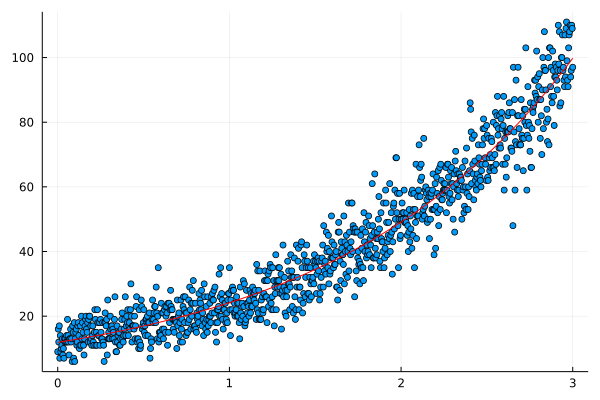

In [71]:
X̃ = [ones(n) LinRange(0,3,n)]
ỹ = exp.(X*β̂)
scatter(X[:, 2], y, legend = false)
plot!(X̃[:, 2], ỹ,  color = :red)